# Q-Learning Agent for Stock Trading

This Q-learning agent is designed to make stock trading decisions based on historical price data. The agent learns an optimal trading strategy through interaction with the market environment using the Q-learning algorithm.

## Agent Architecture

The agent consists of a deep neural network that takes in a state representation and outputs Q-values for each possible action. The state is represented by a sliding window of price differences over a specified window size. The neural network architecture includes an input layer, a hidden layer with ReLU activation, and an output layer with linear activation.

## Q-Learning Process

The Q-learning process follows these steps:

1. **Initialization**: The agent's neural network is initialized with random weights, and the replay memory is emptied.

2. **State Representation**: At each time step, the agent observes the current state of the market, which is represented by a sliding window of price differences.

3. **Action Selection**: The agent selects an action (buy, sell, or hold) based on an epsilon-greedy policy. With probability epsilon, the agent explores by selecting a random action, and with probability 1-epsilon, the agent exploits by selecting the action with the highest Q-value.

4. **State Transition**: The agent executes the selected action and observes the next state and the reward received from the market.

5. **Replay Memory**: The agent stores the transition (state, action, reward, next state, done) in the replay memory.

6. **Q-Value Update**: The agent samples a batch of transitions from the replay memory and updates the Q-values using the Q-learning update rule. The target Q-value for each transition is calculated based on the reward and the maximum Q-value of the next state.

7. **Neural Network Update**: The agent's neural network is updated using the sampled batch of transitions and the Q-learning loss function. The optimizer adjusts the network's weights to minimize the loss.

8. **Iteration**: Steps 3-7 are repeated for a specified number of episodes or until convergence.

## Trading Simulation

The trading simulation is performed using the trained Q-learning agent. The agent makes buy and sell decisions based on the current state of the market. The state is represented by a sliding window of price differences.

The agent's decisions are as follows:

- **Buy**: If the agent selects the buy action and there is sufficient funds, a unit of stock is purchased, and the inventory and balance are updated accordingly.

- **Sell**: If the agent selects the sell action and there is stock in the inventory, a unit of stock is sold, and the balance is updated based on the selling price.

- **Hold**: If the agent selects the hold action, no action is taken.

The simulation keeps track of the buying and selling states, total gains, investment percentage, and the number of shares held at the end.

## Usage

To use the Q-learning agent:

1. Prepare the historical price data as a list of closing prices.

2. Set the initial parameters, such as the initial money, window size, and skip size.

3. Create an instance of the `Agent` class with the desired state size, window size, trend, skip size, batch size, and device.

4. Call the `train` method to train the agent for a specified number of iterations.

5. Evaluate the agent's performance using the `buy` method, which returns the buy and sell states, total gains, investment percentage, and the number of shares held.

The Q-learning agent provides a reinforcement learning approach to optimize a trading strategy based on historical price data. By interacting with the market environment and learning from its experiences, the agent aims to make profitable trading decisions.

In [17]:
from utils import *

import numpy as np
import pandas as pd
from plotly import graph_objects as go
import time

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [6]:
# stock configs
ticker = ['GOOG']
start_date = '2022-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [7]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
close = data['Close'].values
data.head()

(504, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-04-01,140.009995,140.949997,138.796997,140.699997,23480000,0.0,0.0
1,2022-04-04,140.824493,144.043747,140.824493,143.642502,19076000,0.0,0.0
2,2022-04-05,143.399506,143.589996,140.943497,141.063004,19256000,0.0,0.0
3,2022-04-06,139.161499,139.848495,136.418106,137.175995,23574000,0.0,0.0
4,2022-04-07,136.617996,137.701508,134.857254,136.464996,19448000,0.0,0.0


In [18]:
class Deep_Evolution_Strategy:
    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        # Initialize the DES object with the following parameters:
        # - weights: Initial weights of the neural network
        # - reward_function: Function to calculate the reward for a given set of weights
        # - population_size: Number of candidate solutions in each generation
        # - sigma: Noise standard deviation for generating new candidate solutions
        # - learning_rate: Step size for updating the weights
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        # Generate a list of weights by adding random noise to the current weights
        # based on the population and sigma value
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        # Return the current weights of the neural network
        return self.weights

    def train(self, epoch=100, print_every=1):
        # Train the DES agent for a specified number of epochs
        lasttime = time.time()
        for i in range(epoch):
            # Generate a population of candidate solutions
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            # Evaluate the reward for each candidate solution using the reward function
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            # Update the weights based on the rewards using the learning rate
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T
            # Print the reward every 'print_every' epochs
            if (i + 1) % print_every == 0:
                print('iter %d. reward: %f' % (i + 1, self.reward_function(self.weights)))
        print('time taken to train:', time.time() - lasttime, 'seconds')


In [19]:

class Model:
    def __init__(self, input_size, layer_size, output_size):
        # Initialize the neural network model with random weights
        # - input_size: Number of input features
        # - layer_size: Number of hidden units in the layer
        # - output_size: Number of output units
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        # Make predictions using the neural network model
        # - Forward pass through the network to get the output
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        # Return the current weights of the neural network
        return self.weights

    def set_weights(self, weights):
        # Set the weights of the neural network
        self.weights = weights


class Agent:
    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        # Initialize the trading agent with the following parameters:
        # - model: Instance of the neural network model
        # - window_size: Size of the rolling window for input data
        # - trend: Historical price trend data
        # - skip: Number of time steps to skip in each iteration
        # - initial_money: Initial capital for trading
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        # Make a trading decision based on the input sequence using the model
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_state(self, t):
        # Get the state representation at a given time step t
        # - Create a rolling window of price differences
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        # Calculate the reward for a given set of weights
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        # Calculate the percentage return on investment
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        # Train the DES agent for a specified number of iterations
        # - checkpoint: Number of iterations after which to print the progress
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        # Simulate trading based on the trained model
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        # Calculate the percentage return on investment and total gains
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [20]:
close = data.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 3.876890
iter 20. reward: 6.232840
iter 30. reward: 8.372245
iter 40. reward: 8.270555
iter 50. reward: 14.798230
iter 60. reward: 14.870905
iter 70. reward: 13.279080
iter 80. reward: 12.173115
iter 90. reward: 15.230085
iter 100. reward: 11.356035
iter 110. reward: 15.832155
iter 120. reward: 20.802745
iter 130. reward: 24.429134
iter 140. reward: 20.849019
iter 150. reward: 20.291370
iter 160. reward: 20.900590
iter 170. reward: 20.987970
iter 180. reward: 25.093914
iter 190. reward: 24.039670
iter 200. reward: 24.580619
iter 210. reward: 25.709474
iter 220. reward: 26.543110
iter 230. reward: 26.646920
iter 240. reward: 26.958725
iter 250. reward: 27.683255
iter 260. reward: 23.499925
iter 270. reward: 23.752010
iter 280. reward: 28.462034
iter 290. reward: 26.452014
iter 300. reward: 28.507464
iter 310. reward: 29.226559
iter 320. reward: 28.231060
iter 330. reward: 25.357345
iter 340. reward: 28.472555
iter 350. reward: 29.776280
iter 360. reward: 29.063685
iter 

In [23]:
# Evaluate the agent's performance
states_buy, states_sell, total_gains, invest = agent.buy()

day 4: buy 1 unit at price 136.464996, total balance 9863.535004
day 5: buy 1 unit at price 134.010498, total balance 9729.524506
day 8: buy 1 unit at price 130.285995, total balance 9599.238510
day 9: buy 1 unit at price 127.252998, total balance 9471.985512
day 11: buy 1 unit at price 130.531006, total balance 9341.454506
day 12: buy 1 unit at price 128.245499, total balance 9213.209007
day 14: buy 1 unit at price 119.613998, total balance 9093.595009
day 15: buy 1 unit at price 123.250000, total balance 8970.345009
day 16: buy 1 unit at price 119.505997, total balance 8850.839012
day 17: buy 1 unit at price 115.020500, total balance 8735.818512
day 18: buy 1 unit at price 119.411499, total balance 8616.407013
day 19: buy 1 unit at price 114.966499, total balance 8501.440514
day 20: buy 1 unit at price 117.156998, total balance 8384.283516
day 21: buy 1 unit at price 118.129501, total balance 8266.154015
day 22: buy 1 unit at price 122.574997, total balance 8143.579018
day 23: buy 1 

In [24]:
import plotly.graph_objects as go

starting_money = 10000

close = data['Close']
final_share_price = close[len(close) - 1]  # Final share price
total_portfolio_value = starting_money + total_gains  # Total portfolio value
total_gains = total_portfolio_value - starting_money

fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close']))

# Buy signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_buy],
                         y=[close[i] for i in states_buy],
                         mode='markers',
                         name='Buy Signals',
                         marker=dict(symbol='triangle-up', size=10, color='green')))

# Sell signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_sell],
                         y=[close[i] for i in states_sell],
                         mode='markers',
                         name='Sell Signals',
                         marker=dict(symbol='triangle-down', size=10, color='red')))

# Set layout
fig.update_layout(
    title=f'Total Gains: {total_gains:.2f}, Total Portfolio Value: {total_portfolio_value:.2f}',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    legend=dict(x=0, y=1, orientation='h')
)

fig.show()

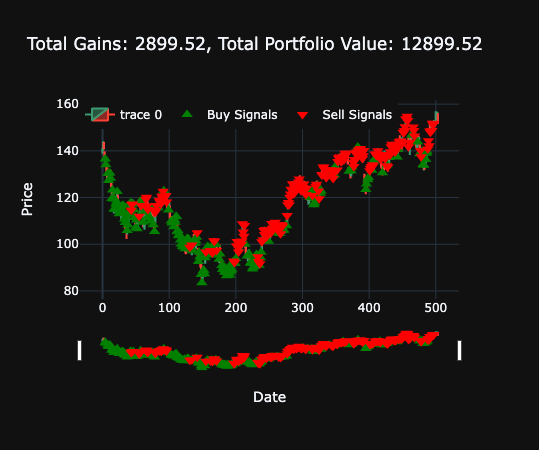